In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,roc_auc_score,roc_curve


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

In [4]:
data=pd.read_csv("/kaggle/input/loan-stats/Loan_status_2007-2020Q3.csv",low_memory=False)

In [5]:
def train_test_splitting(data):
    train,test = train_test_split(data,test_size=0.8,random_state=42)
    return train,test

In [6]:
data1=data[["loan_status","addr_state"]]

In [7]:
data1 = data1.copy()  


In [8]:

risk_mapping = {
    "Fully Paid": 0,  
    "Current": 0,      
    "Issued": 0,      
    "In Grace Period": 1,
    "Late (16-30 days)": 1,
    "Late (31-120 days)": 1,
    "Charged Off": 1,
    "Default": 1,
    "Does not meet the credit policy. Status:Fully Paid": 0,
    "Does not meet the credit policy. Status:Charged Off": 1
}

data1.loc[:, "loan_status_num"] = data1["loan_status"].map(risk_mapping)


In [9]:

grouped_data = data1.groupby("addr_state")["loan_status_num"].mean()

default_percentage = (grouped_data) * 100

state_default_dict = default_percentage.to_dict()

print(state_default_dict)

{'AK': 13.121834971700924, 'AL': 15.841156482174739, 'AR': 16.025525795434117, 'AZ': 13.275481897716764, 'CA': 13.736576012019194, 'CO': 10.889828433373056, 'CT': 11.966893239273539, 'DC': 9.937611408199643, 'DE': 12.961424332344212, 'FL': 14.66480841486727, 'GA': 12.562048561095162, 'HI': 14.64082266775172, 'IA': 21.428571428571427, 'ID': 9.00689452838492, 'IL': 11.994299806295814, 'IN': 13.849287169042771, 'KS': 11.399470360562233, 'KY': 13.354223145442381, 'LA': 15.352620955410117, 'MA': 13.01764627442846, 'MD': 14.357606778786183, 'ME': 7.536231884057972, 'MI': 13.364917588980013, 'MN': 13.314867939459887, 'MO': 13.86917486105173, 'MS': 16.031576448243115, 'MT': 11.167883211678832, 'NC': 13.81970329046432, 'ND': 10.857029230463313, 'NE': 13.360507246376812, 'NH': 10.281980742778542, 'NJ': 13.752804786836201, 'NM': 14.085051546391753, 'NV': 15.347642720825577, 'NY': 15.010185709576257, 'OH': 13.00998779958229, 'OK': 15.47196593328602, 'OR': 9.718604914505718, 'PA': 13.75345878557061

In [10]:
#WE MAY HAVE SOME OUTLIERS SO WE ARE USING MEDIAN VALUES
median_default = np.median(list(state_default_dict.values()))


high_risk_states = [state for state, rate in state_default_dict.items() if rate > median_default]
low_risk_states = [state for state, rate in state_default_dict.items() if rate <= median_default]


print("High Risk States:", high_risk_states)
print("Low Risk States:", low_risk_states)


High Risk States: ['AL', 'AR', 'CA', 'FL', 'HI', 'IA', 'IN', 'KY', 'LA', 'MD', 'MI', 'MN', 'MO', 'MS', 'NC', 'NE', 'NJ', 'NM', 'NV', 'NY', 'OK', 'PA', 'SD', 'TN', 'VA']
Low Risk States: ['AK', 'AZ', 'CO', 'CT', 'DC', 'DE', 'GA', 'ID', 'IL', 'KS', 'MA', 'ME', 'MT', 'ND', 'NH', 'OH', 'OR', 'RI', 'SC', 'TX', 'UT', 'VT', 'WA', 'WI', 'WV', 'WY']


In [11]:
def encode_target(data, column):
    
    risk_mapping = {
        'Fully Paid': 0,  
        'Current': 0,
        'Issued': 0,
        'In Grace Period': 1,
        'Late (16-30 days)': 1,
        'Late (31-120 days)': 1,
        'Charged Off': 1,
        'Default': 1,
        'Does not meet the credit policy. Status:Fully Paid': 0,
        'Does not meet the credit policy. Status: Charged Off': 1
    }


    data[column] = data[column].map(risk_mapping)


    data[column] = data[column].fillna(0)
    
    return data


In [12]:
def feature_selection(data):
    data = handle_missing_value(data)
    data = data.drop(columns=[
        "id", "url","emp_title","title", "zip_code",
        "funded_amnt","funded_amnt_inv", "issue_d",
        "pymnt_plan","initial_list_status","out_prncp", "out_prncp_inv",
        "total_pymnt", "total_pymnt_inv", "total_rec_prncp", "total_rec_int",
        "total_rec_late_fee", "recoveries", "collection_recovery_fee",
        "last_pymnt_d", "last_pymnt_amnt", "next_pymnt_d", "last_credit_pull_d",
        "earliest_cr_line","policy_code","application_type", "hardship_flag"
        ,"debt_settlement_flag","orig_projected_additional_accrued_interest"
    ])  
    
  
    missing_thresh = 0.5  # 50%
    missing_ratio = data.isnull().mean()
    to_drop_missing = missing_ratio[missing_ratio > missing_thresh].index
    data.drop(columns=to_drop_missing, inplace=True)

    low_variance_thresh = 0.95  # 95% same value
    to_drop_low_variance = [
        col for col in data.columns
        if data[col].value_counts(normalize=True, dropna=False).values[0] > low_variance_thresh
    ]
    data.drop(columns=to_drop_low_variance, inplace=True)

    cat_thresh = 0.01  # 1% of rows
    for col in data.select_dtypes(include='object'):
        rare_levels = data[col].value_counts(normalize=True) < cat_thresh
        if rare_levels.sum() / len(data[col].unique()) > 0.5:  # More than half rare
            data.drop(columns=col, inplace=True)

    return data


In [13]:


def feature_eng(data):
    cols_to_convert = ["annual_inc", "loan_amnt", "revol_bal", "revol_util"]
   
    for col in cols_to_convert:
        data[col] = pd.to_numeric(data[col], errors="coerce")
    data["avg_fico"] = (data["fico_range_low"] + data["fico_range_high"]) // 2
    data["Debt_to_income_ratio"] = data["total_bal_ex_mort"] / data["annual_inc"]
    data["total_cred_lines"] = data["open_acc"] / data["total_acc"]
  
    data["high_credit_risk"] = 0  
    data.loc[(data["delinq_2yrs"] > 0) | (data["pub_rec"] > 0), "high_credit_risk"] = 1
    data["cred_inquiry_risk"] = 1 
    data.loc[data["inq_last_6mths"] == 0, "cred_inquiry_risk"] = 0
    data.loc[(data["inq_last_6mths"] >= 1) & (data["inq_last_6mths"] <= 3), "cred_inquiry_risk"] = 1
    data.loc[(data["inq_last_6mths"] >= 4) & (data["inq_last_6mths"] <= 6), "cred_inquiry_risk"] = 2
    data.loc[data["inq_last_6mths"] >= 7, "cred_inquiry_risk"] = 3
    data["income_loan_ratio"] = data["annual_inc"] / data["loan_amnt"]
    denominator = data["revol_util"].replace(0, np.nan).fillna(1e-6)

    numerator = data["revol_bal"].fillna(data["revol_bal"].median())

    data["revol_util_eff"] = numerator / denominator

    
    data["revol_util_eff"] = data["revol_util_eff"].fillna(data["revol_util_eff"].median())
    state_risk_mapping = {state: 1 if state in high_risk_states else 0 for state in state_default_dict}
    data["state_risk"] = data["addr_state"].map(state_risk_mapping)
    data = data.drop(columns=[
        "fico_range_low", "fico_range_high", "total_bal_ex_mort",
        "open_acc", "total_acc", "delinq_2yrs", "pub_rec", 
        "inq_last_6mths", "addr_state", "revol_bal", "revol_util",
        "annual_inc", "loan_amnt"
    ])
    
    return data


In [14]:
def encode_categorical(data):
    categorical_features = data.select_dtypes(include=["object", "category"]).columns
    encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    data[categorical_features] = encoder.fit_transform(data[categorical_features])
    return data

In [15]:
def fix_infinite_values(data):
    
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    
    data.fillna(data.median(), inplace=True)  
 
    
    return data

In [16]:

def handle_missing_value(data):
    
    data = data.copy()
    

    numerical_columns = data.select_dtypes(include=['number']).columns
    categorical_columns = data.select_dtypes(include=['object', 'category', 'bool']).columns
    
  
    data[numerical_columns] = data[numerical_columns].apply(pd.to_numeric, errors='coerce')
    
 
    data[categorical_columns] = data[categorical_columns].astype('category')
    

    for col in numerical_columns:
        if data[col].isna().all():
           
            data[col] = 0 
        else:
            data[col] = data[col].fillna(data[col].mean())
    
   
    for col in categorical_columns:
        if data[col].isna().all() or len(data[col].dropna()) == 0:
          
            data[col] = "Unknown"
        else:
       
            most_common = data[col].mode()
            if len(most_common) > 0:
                data[col] = data[col].fillna(most_common[0])
            else:
                data[col] = data[col].fillna("Unknown")
    
    return data


In [17]:


def app_pca(data, n_components=10):
    
    
   
    numeric_features = data.select_dtypes(include=["number"])
    
    numeric_features = numeric_features.fillna(numeric_features.mean())

    
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(numeric_features)
    
   
    pca_df = pd.DataFrame(principal_components, columns=[f"PC{i+1}" for i in range(n_components)])

    return pca_df



In [18]:
def target_feature_splitting(train,test):
    X_train=train.drop("loan_status", axis=1)
    X_test=test.drop("loan_status", axis=1)
    Y_train=train["loan_status"]
    Y_test=test["loan_status"]
    return X_train, X_test, Y_train, Y_test

In [19]:
def model_random_forest(X_train, Y_train, X_test, Y_test):
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

    rf_model.fit(X_train, Y_train)

    
    y_pred = rf_model.predict(X_test)

  
    accuracy = accuracy_score(Y_test, y_pred)
    print(f"Random Forest Accuracy: {accuracy:.4f}")

    print("\nClassification Report:")
    print(classification_report(Y_test, y_pred,zero_division=0))

    print("\nConfusion Matrix:")
    print(confusion_matrix(Y_test, y_pred))

    if hasattr(rf_model, "predict_proba"):
        y_proba = rf_model.predict_proba(X_test)[:, 1]
    print("ROC-AUC Score:", roc_auc_score(Y_test, y_proba))

    cm = confusion_matrix(Y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(Y_test, y_proba)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(Y_test, y_proba):.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()
    return rf_model  
    

In [20]:
def pipeline(data):
   
    
    
    train, test = train_test_splitting(data)
    print(train.shape)
    
   
    train = encode_target(train, "loan_status")
    test = encode_target(test, "loan_status")


    train = feature_selection(train)
    test = feature_selection(test)
 
    
    train = feature_eng(train)
    test = feature_eng(test)
   

    train = encode_categorical(train)
    test = encode_categorical(test)

    train=fix_infinite_values(train)
    test=fix_infinite_values(test)
    
    train=handle_missing_value(train)
    test=handle_missing_value(test)
    
    print(train.shape)
    X_train, X_test, Y_train, Y_test=target_feature_splitting(train,test)
    print(X_train.shape,Y_train.shape)
    
    X_train = app_pca(X_train)
    X_test = app_pca(X_test)
    print(X_train.shape)
    print(Y_train.shape)
  
    model=model_random_forest(X_train, Y_train, X_test, Y_test)

    return model


(585098, 142)
(585098, 91)
(585098, 90) (585098,)
(585098, 10)
(585098,)
Random Forest Accuracy: 0.8661

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93   2027022
         1.0       0.00      0.00      0.00    313373

    accuracy                           0.87   2340395
   macro avg       0.43      0.50      0.46   2340395
weighted avg       0.75      0.87      0.80   2340395


Confusion Matrix:
[[2027022       0]
 [ 313373       0]]
ROC-AUC Score: 0.6079891536173236


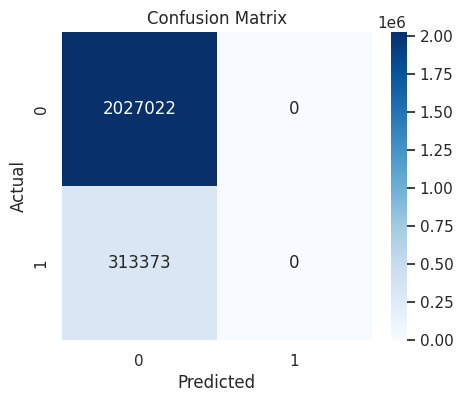

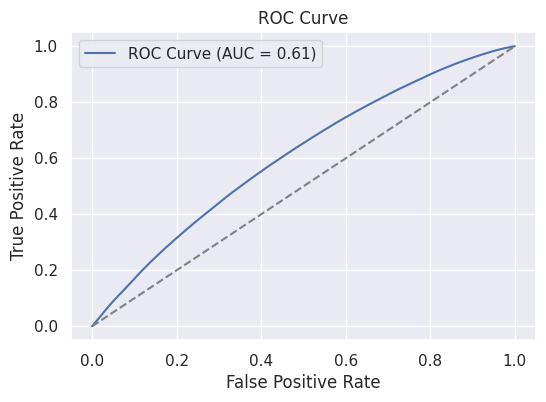

RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

In [21]:
pipeline(data)

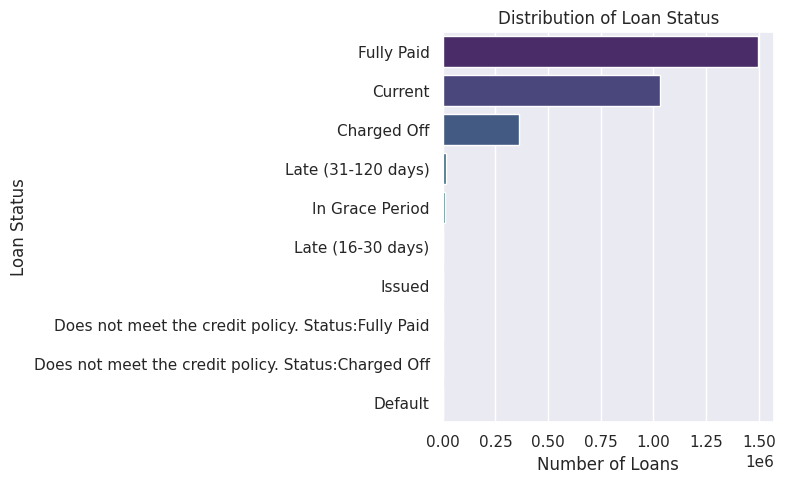

In [23]:
plt.figure(figsize=(8, 5))
sns.countplot(data=data, y='loan_status', order=data['loan_status'].value_counts().index, palette='viridis')
plt.title('Distribution of Loan Status')
plt.xlabel('Number of Loans')
plt.ylabel('Loan Status')
plt.tight_layout()
plt.show()

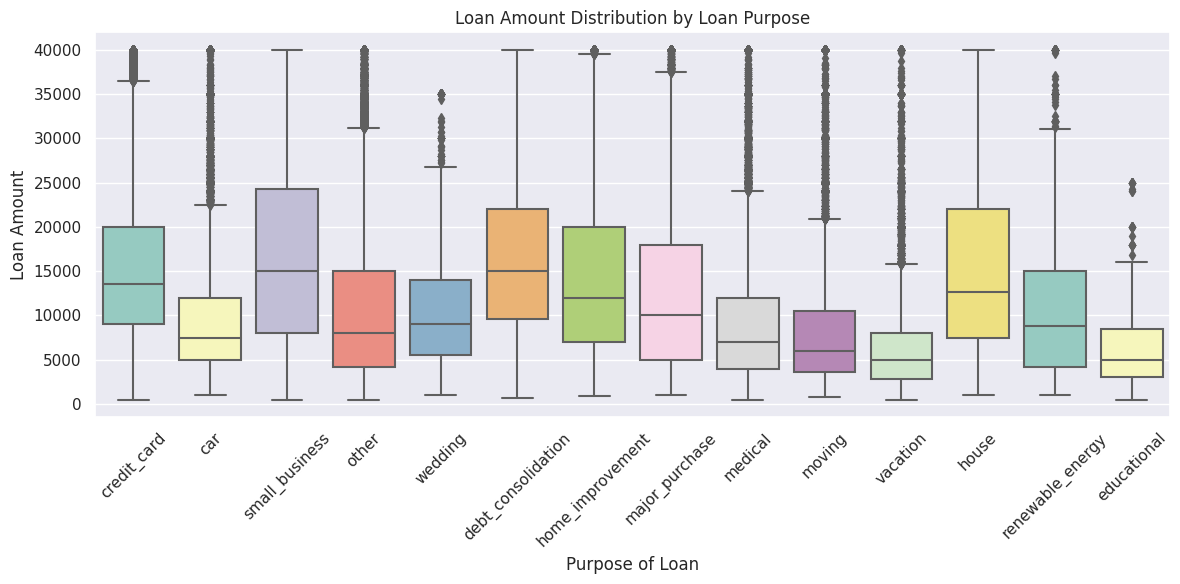

In [24]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='purpose', y='loan_amnt', palette='Set3')
plt.xticks(rotation=45)
plt.title('Loan Amount Distribution by Loan Purpose')
plt.xlabel('Purpose of Loan')
plt.ylabel('Loan Amount')
plt.tight_layout()
plt.show()

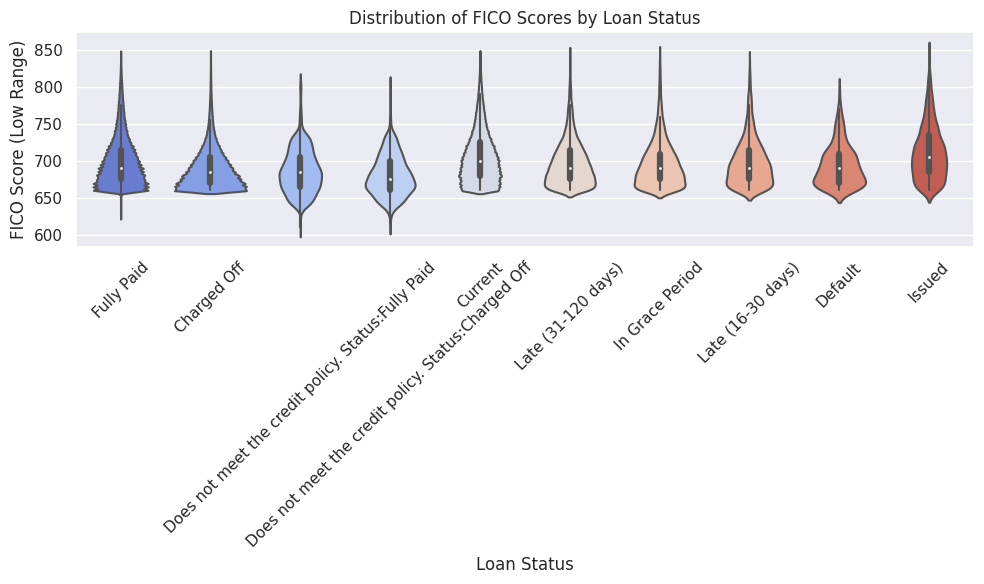

In [25]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=data, x='loan_status', y='fico_range_low', palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Distribution of FICO Scores by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('FICO Score (Low Range)')
plt.tight_layout()
plt.show()


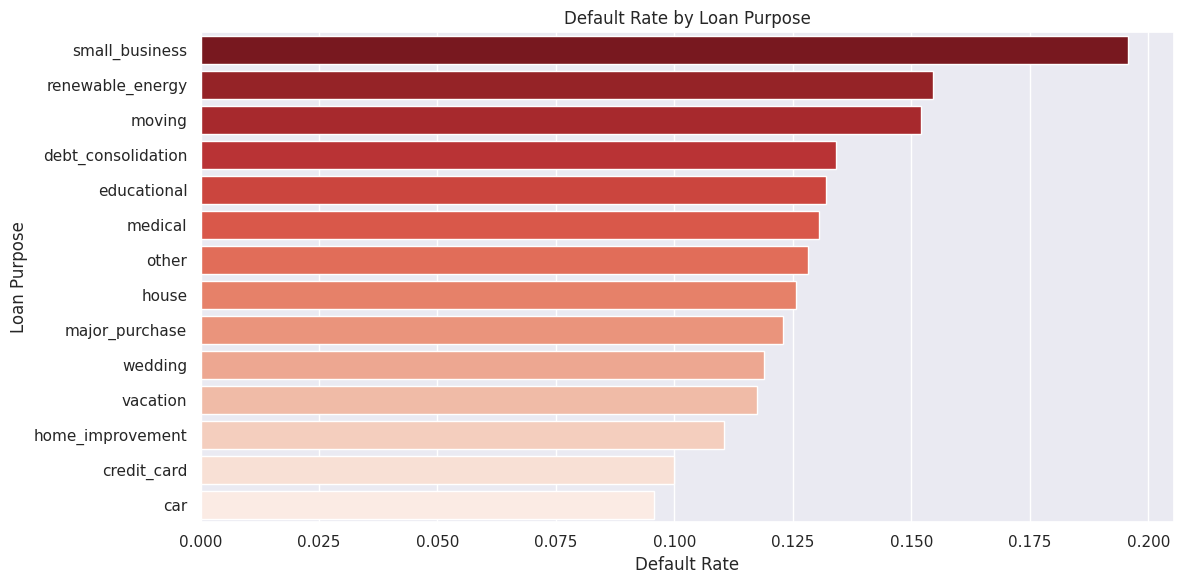

In [26]:
plt.figure(figsize=(12, 6))


df_temp = data[data['loan_status'].isin(['Charged Off', 'Fully Paid'])]

df_temp = data[data['loan_status'].notnull()].copy()
df_temp.loc[:, 'default'] = df_temp['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)



default_rate_by_purpose = df_temp.groupby('purpose')['default'].mean().sort_values(ascending=False)


sns.barplot(x=default_rate_by_purpose.values, y=default_rate_by_purpose.index, palette='Reds_r')
plt.xlabel('Default Rate')
plt.ylabel('Loan Purpose')
plt.title('Default Rate by Loan Purpose')
plt.tight_layout()
plt.show()


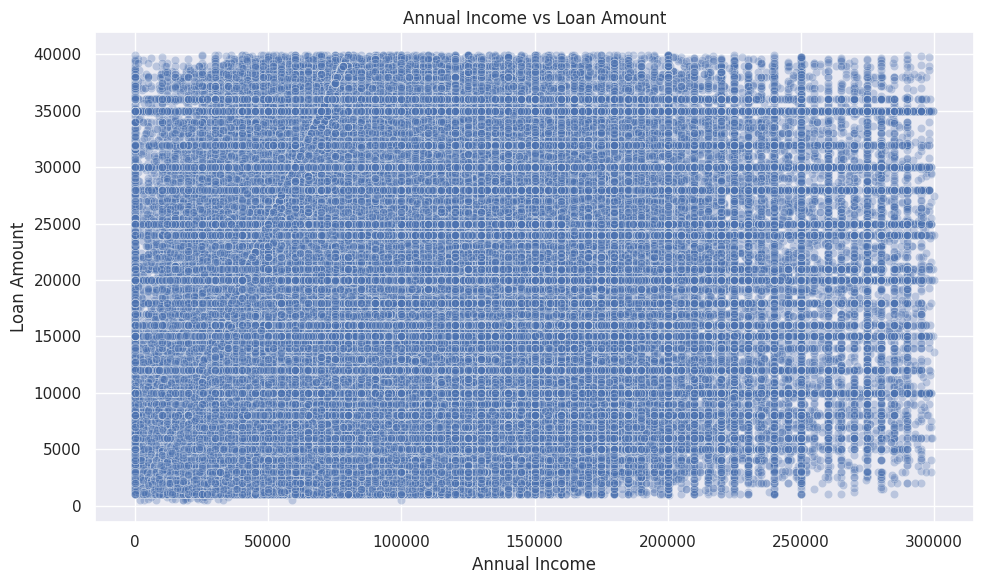

In [27]:
plt.figure(figsize=(10, 6))


filtered_df = data[(data['annual_inc'] < 300000) & (data['loan_amnt'] < 40000)]


sns.scatterplot(data=filtered_df, x='annual_inc', y='loan_amnt', alpha=0.3)
plt.xlabel('Annual Income')
plt.ylabel('Loan Amount')
plt.title('Annual Income vs Loan Amount')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

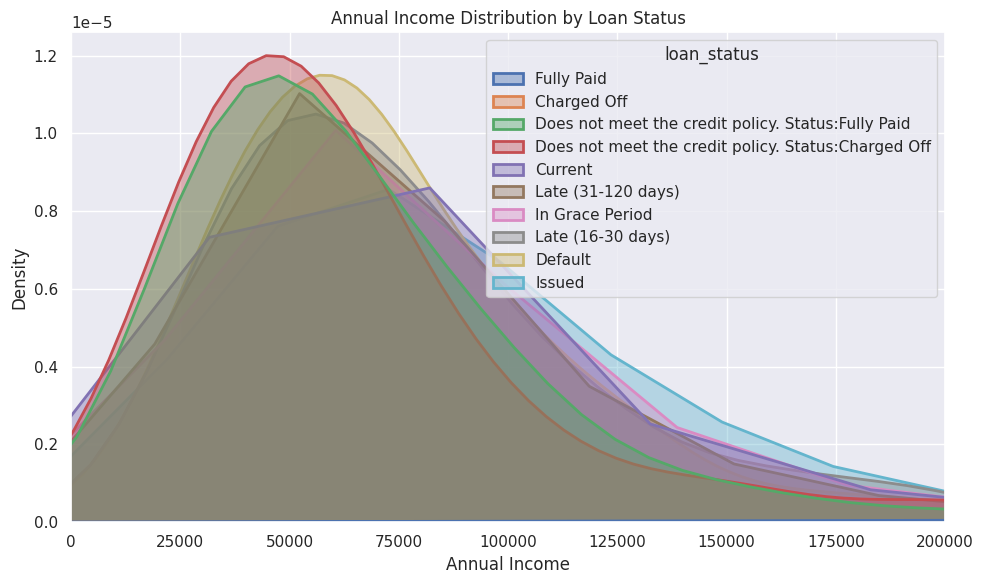

In [28]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=data, x="annual_inc", hue="loan_status", fill=True, common_norm=False, alpha=0.4, linewidth=2)
plt.xlim(0, 200000)  # optional: cap at 200k to avoid long tails
plt.title("Annual Income Distribution by Loan Status")
plt.xlabel("Annual Income")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()